# Experiment with the pipeline using a sampled dataset

In [1]:
import os

import apache_beam as beam
import apache_beam.runners.interactive.interactive_beam as ib

from apache_beam.runners.interactive.interactive_runner import InteractiveRunner
from apache_beam.runners.dataflow import DataflowRunner

In [2]:
!gsutil cat gs://apache-beam-samples/nyc_taxi/misc/sample10000.csv | head -n 10

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount

1,2018-01-01 00:21:05,2018-01-01 00:24:23,1,.50,1,N,41,24,2,4.5,0.5,0.5,0,0,0.3,5.8
1,2018-01-01 00:44:55,2018-01-01 01:03:05,1,2.70,1,N,239,140,2,14,0.5,0.5,0,0,0.3,15.3
1,2018-01-01 00:08:26,2018-01-01 00:14:21,2,.80,1,N,262,141,1,6,0.5,0.5,1,0,0.3,8.3
1,2018-01-01 00:20:22,2018-01-01 00:52:51,1,10.20,1,N,140,257,2,33.5,0.5,0.5,0,0,0.3,34.8
1,2018-01-01 00:09:18,2018-01-01 00:27:06,2,2.50,1,N,246,239,1,12.5,0.5,0.5,2.75,0,0.3,16.55
1,2018-01-01 00:29:29,2018-01-01 00:32:48,3,.50,1,N,143,143,2,4.5,0.5,0.5,0,0,0.3,5.8
1,2018-01-01 00:38:08,2018-01-01 00:48:24,2,1.70,1,N,50,239,1,9,0.5,0.5,2.05,0,0.3,12.35
1,2018-01-01 00:49:29,2018-01-01 00:51:53,1,.70,1,N,

In [3]:
p = beam.Pipeline(InteractiveRunner())

In [4]:
bdf = p | beam.dataframe.io.read_csv('gs://apache-beam-samples/nyc_taxi/misc/sample100000.csv',
                                     parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'],
                                     splittable=True)

Beam's `read_csv()` peeks at the input data so we know what the column names and types are while constructing the pipeline:

In [6]:
bdf.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
RatecodeID                        int64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
dtype: object

Similarly, when you perform some computation (like aggregating the number of passengers picked up by hour of day), Beam keeps track of the name and types of columns so it knows what operations are valid.

In [7]:
passengers_by_pickup_hour = bdf.passenger_count.groupby(bdf.tpep_pickup_datetime.dt.hour).sum()
passengers_by_pickup_hour

DeferredSeries(name='passenger_count', dtype=int64, index='tpep_pickup_datetime')

We can use `ib.collect()` to trigger execution and bring the result back into the notebook kernel's memory as a concrete pandas object:

In [8]:
ib.collect(passengers_by_pickup_hour).sort_index()

tpep_pickup_datetime
0     28630
1     32778
2     27964
3     21240
4     14822
5      7109
6      5423
7      5481
8      5886
9      8094
10    11460
11      168
12        8
16       27
17       57
18       28
19        6
20       19
21       99
22       44
23      199
Name: passenger_count, dtype: int64

Most of the pandas API is available to you in the Beam DataFrame API, and you can compose operations as you would with pandas. For example, we can compute the tip ratio for each ride, then aggregate that by the time of day to look for a correlation:

In [9]:
tip_ratio = bdf.tip_amount/bdf.total_amount
tip_ratio.name = "tip_ratio"
tip_ratio_by_pickup_hour = tip_ratio.groupby(bdf.tpep_pickup_datetime.dt.hour).mean()
tip_ratio_by_pickup_hour

DeferredSeries(name='tip_ratio', dtype=float64, index='tpep_pickup_datetime')

In [10]:
result = ib.collect(tip_ratio_by_pickup_hour).sort_index()
result

tpep_pickup_datetime
0     0.094983
1     0.099037
2     0.098171
3     0.094328
4     0.083468
5     0.075163
6     0.074074
7     0.080311
8     0.083549
9     0.084707
10    0.086747
11    0.096448
12    0.081391
16    0.093374
17    0.118248
18    0.049625
19    0.147057
20    0.105457
21    0.097772
22    0.059851
23    0.086627
Name: tip_ratio, dtype: float64

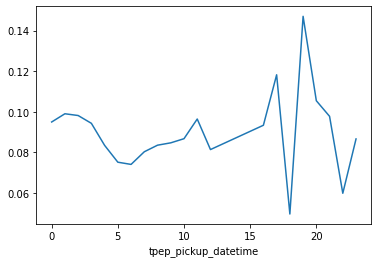

In [11]:
fig = result.plot()

It looks like we don't have enough data here to really see a trend. There might be a trend based on the morning hours, but it seems the data is too noisy in the afternoon.

Let's scale this up!

# Process the full dataset with a distributed runner

Now that we've prototyped some analytics interactively, we can scale up the same code by switching to a distributed runner.

In [12]:
PROJECT_ID = "<my-gcp-project>"
REGION = "us-west1"
TEMP_DIR = "gs://<my-bucket>/tmp"
OUTPUT_DIR = "gs://<my-bucket>/dataframe-result"

In [13]:
# Build a new pipeline that will execute on Dataflow.
p = beam.Pipeline(DataflowRunner(),
                  options=beam.options.pipeline_options.PipelineOptions(
                      project=PROJECT_ID,
                      region=REGION,
                      temp_location=TEMP_DIR,
                      # Disable autoscaling for a quicker demo
                      autoscaling_algorithm='NONE',
                      num_workers=10))

In [14]:
!gsutil ls gs://apache-beam-samples/nyc_taxi/2018/*.csv

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
gs://apache-beam-samples/nyc_taxi/2018/yellow_tripdata_2018-01.csv
gs://apache-beam-samples/nyc_taxi/2018/yellow_tripdata_2018-02.csv
gs://apache-beam-samples/nyc_taxi/2018/yellow_tripdata_2018-03.csv
gs://apache-beam-samples/nyc_taxi/2018/yellow_tripdata_2018-04.csv
gs://apache-beam-samples/nyc_taxi/2018/yellow_tripdata_2018-05.csv
gs://apache-beam-samples/nyc_taxi/2018/yellow_tripdata_2018-06.csv
gs://apache-beam-samples/nyc_taxi/2018/yellow_tripdata_2018-07.csv
gs://apache-beam-samples/nyc_taxi/2018/yellow_tripdata_2018-08.csv
gs://apache-beam-samples/nyc_taxi/2018/yellow_tripdata_2018-09.csv
gs://apache-beam-samples/nyc_taxi/2018/yellow_tripdata_2018-10.csv
gs://apache-beam-samples/nyc_taxi/2018/yellow_tripdata_2018-11.csv
gs://apache-beam-samples/nyc_taxi/2018/yellow_tripdata_2018-12.csv


In [15]:
bdf = p | beam.dataframe.io.read_csv('gs://apache-beam-samples/nyc_taxi/2018/*.csv',
                                     parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'],
                                     splittable=True)

In [16]:
bdf.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
RatecodeID                        int64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
dtype: object

In [17]:
tip_ratio = bdf.tip_amount/bdf.total_amount
tip_ratio.name = 'tip_ratio'
tip_ratio_by_pickup_hour = tip_ratio.groupby(bdf.tpep_pickup_datetime.dt.hour).mean()
tip_ratio_by_pickup_hour

DeferredSeries(name='tip_ratio', dtype=float64, index='tpep_pickup_datetime')

In [18]:
passengers_by_pickup_hour = bdf.passenger_count.groupby(bdf.tpep_pickup_datetime.dt.hour).sum()
passengers_by_pickup_hour

DeferredSeries(name='passenger_count', dtype=int64, index='tpep_pickup_datetime')

In [19]:
tip_ratio_by_pickup_hour.to_csv(os.path.join(OUTPUT_DIR, "tip_ratio.csv"))
passengers_by_pickup_hour.to_csv(os.path.join(OUTPUT_DIR, "passengers.csv"))

/root/apache-beam-2.37.0/lib/python3.7/site-packages/apache_beam/dataframe/io.py:632: FutureWarning: WriteToFiles is experimental.
  sink=lambda _: _WriteToPandasFileSink(
/root/apache-beam-2.37.0/lib/python3.7/site-packages/apache_beam/dataframe/io.py:632: FutureWarning: WriteToFiles is experimental.
  sink=lambda _: _WriteToPandasFileSink(


<PCollection[[19]: WriteToPandas(df) - gs://bhulette-test/dataframe-result/passengers.csv/WriteToFiles/ParDo(_MoveTempFilesIntoFinalDestinationFn).None] at 0x7f9140b979d0>

In [21]:
p.run().wait_until_finish()

'DONE'

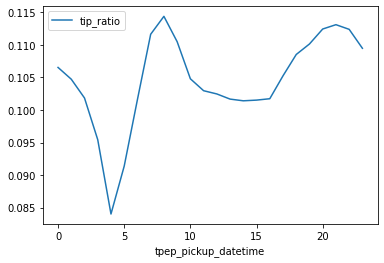

In [22]:
# Use interactive Beam + Beam DataFrames to read and plot the tip ratio result CSV 
p = beam.Pipeline(InteractiveRunner())
bdf = p | beam.dataframe.io.read_csv(os.path.join(OUTPUT_DIR, "tip_ratio*"))
fig = ib.collect(bdf.set_index('tpep_pickup_datetime')).sort_index().plot()

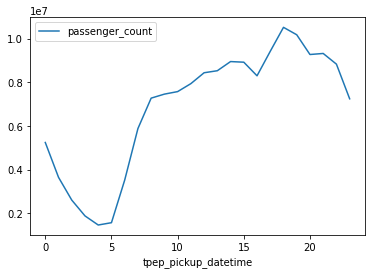

In [23]:
# Use interactive Beam + Beam DataFrames to read and plot the passenger count result CSV 
p = beam.Pipeline(InteractiveRunner())
bdf = p | beam.dataframe.io.read_csv(os.path.join(OUTPUT_DIR, "passengers*"))
fig = ib.collect(bdf.set_index('tpep_pickup_datetime')).sort_index().plot()

# Differences from pandas

While the Beam DataFrame API does support the vast majority of pandas operations, there are some operations in the pandas API that are difficult or impossible to implement faithfully in Beam (see the [documentation](https://beam.apache.org/documentation/dsls/dataframes/differences-from-pandas/) on this topic). We will always warn you about these operations. For example:

In [24]:
p = beam.Pipeline(InteractiveRunner())
bdf = p | beam.dataframe.io.read_csv('gs://apache-beam-samples/nyc_taxi/2018/*.csv',
                                     parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'],
                                     splittable=True)

In [25]:
# Non-parallelizable operation
passenger_mode = bdf.passenger_count.mode()

NonParallelOperation: (NonParallelOperation(...), "mode cannot currently be parallelized. See BEAM-12181 tracking the possble addition of an approximate, parallelizable implementation of mode.\nConsider using an allow_non_parallel_operations block if you're sure you want to do this. See https://s.apache.org/dataframe-non-parallel-operations for more information.")

In [26]:
# opt-in to collecting the dataset on the single node (for example, if you know it's been aggregated and is small enough)
with beam.dataframe.allow_non_parallel_operations():
    passenger_mode = bdf.passenger_count.mode()

In [27]:
# Order-sensitive operation
bdf.passenger_count.diff()

WontImplementError: 'diff' is not yet supported because it is sensitive to the order of the data.
For more information see https://s.apache.org/dataframe-order-sensitive-operations.

In [28]:
passengers_by_pickup_hour = bdf.passenger_count.groupby(bdf.tpep_pickup_datetime.dt.hour).sum()

passengers_by_pickup_hour.plot()

WontImplementError: 'plot' is not yet supported because it is a plotting tool.
For more information see https://s.apache.org/dataframe-plotting-tools.